In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

import torch_nf
from torch_nf.conditional_nf import NormFlow, ConditionedNormFlow
from torch_nf.error_formatters import dbg_check
from torch_nf.systems import MF_V1
from torch_nf.util import plot_dist
from torch_nf.lfi import train_SNPE, train_APT

import scipy.stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
system = MF_V1()

z0 = np.array([[1.3, -1.3, 1.3, -1.0, 0.2, 0.2, 0.2, 0.2]])

x0 = system.simulate(z0)
print(z0)
print(x0)

[[ 1.3 -1.3  1.3 -1.   0.2  0.2  0.2  0.2]]
[[0.65982722 0.87112975 1.00751109 0.80225288 1.12080909 1.38230618
  0.31440477 0.4132955  0.59406397 0.31440477 0.4132955  0.59406397]]


In [3]:
from torch_nf.bijectors import ToInterval
# Opt params
D = system.D
M = 2000
M_atom = 100
num_iters = 2000
R = 4

# two-network arch
arch_type = 'autoregressive'
hidden_layers = [64]

rs = 1
np.random.seed(rs)
torch.manual_seed(rs)

#lb = -float('inf')*np.ones((D,)) #system.lb
#ub = float('inf')*np.ones((D,)) #system.ub
lb = system.lb
ub = system.ub
support_layer = ToInterval(D, lb, ub)

nf = NormFlow(D, arch_type, True, num_stages=1, 
              num_layers=2, num_units=25, support_layer=support_layer)
cnf = ConditionedNormFlow(nf, x0.shape[1], hidden_layers, dropout=False)
print(cnf.param_net)

Sequential(
  (linear1): Linear(in_features=12, out_features=64, bias=True)
  (tanh1): Tanh()
  (linear2): Linear(in_features=64, out_features=2066, bias=True)
)


### Run SNPE

M 2000


<Figure size 432x288 with 0 Axes>

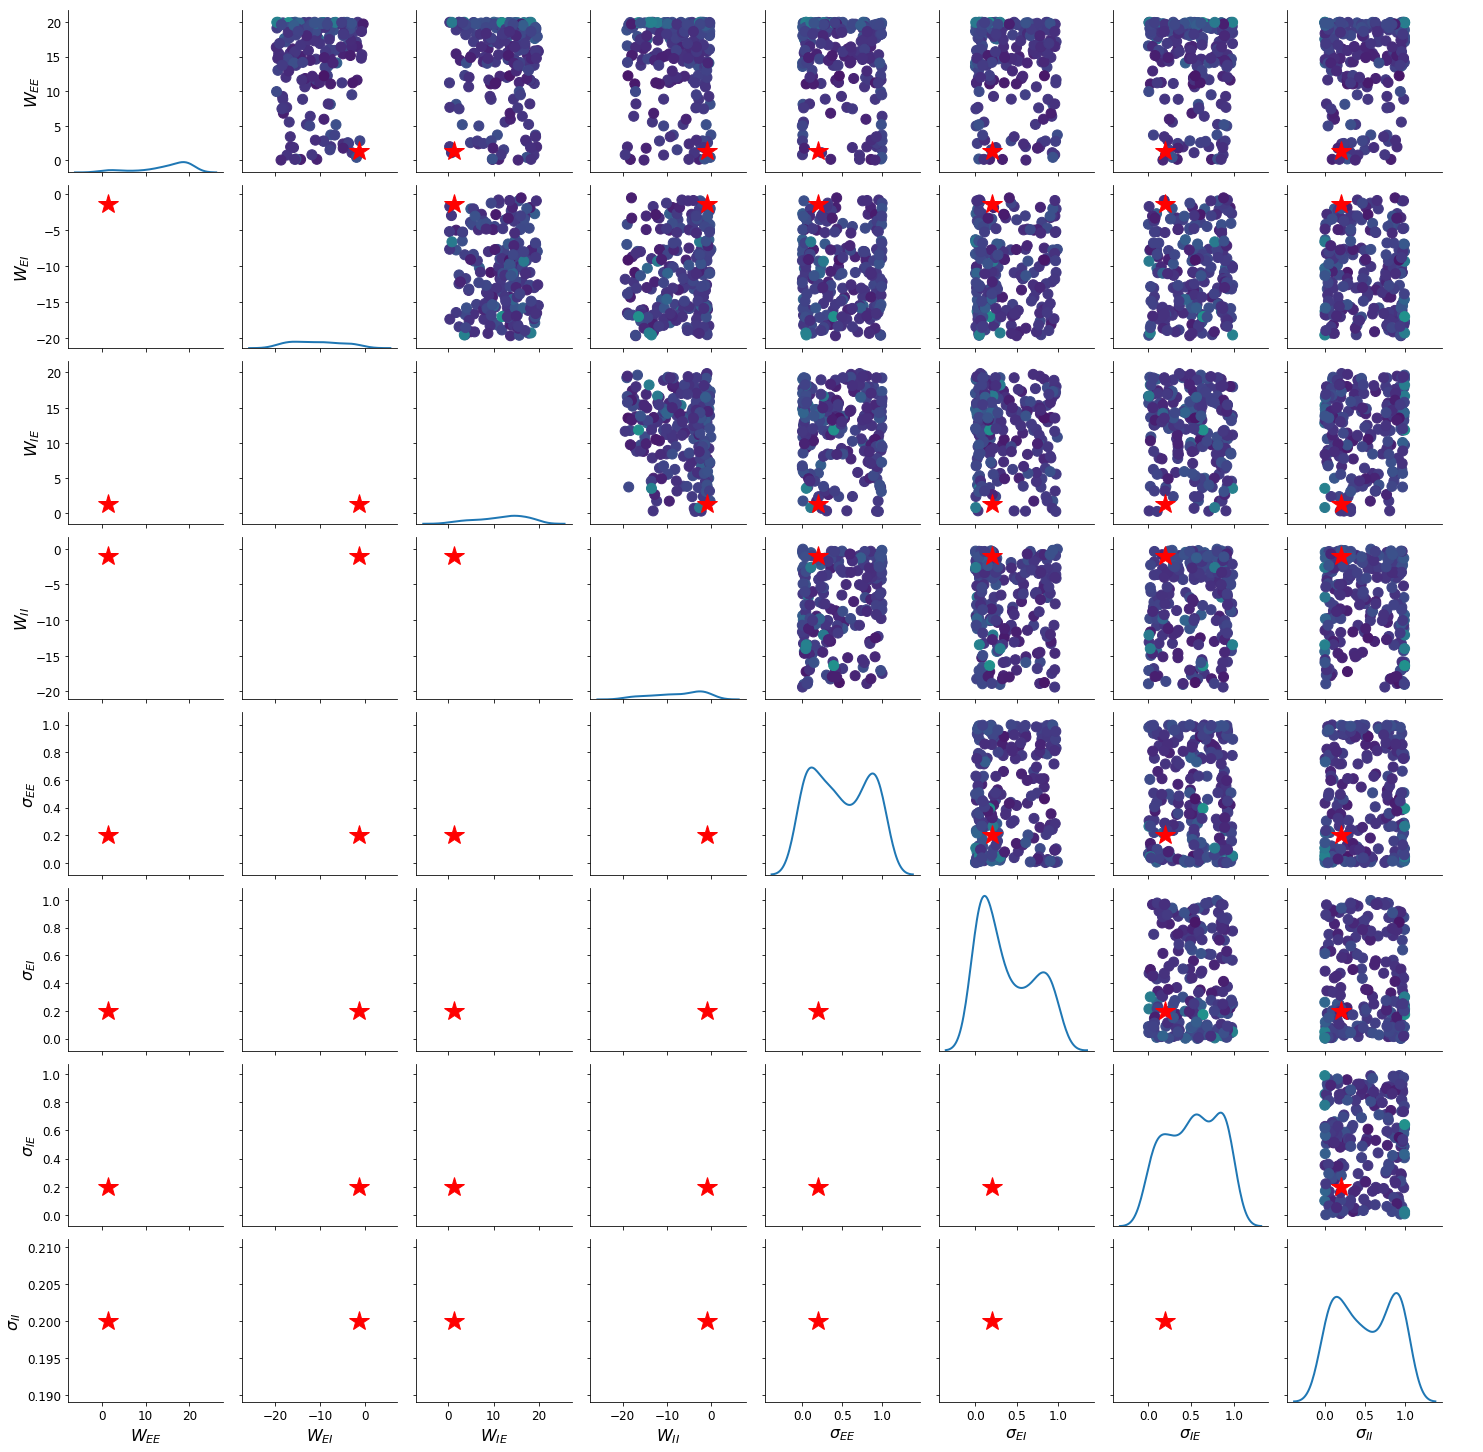

M 2000
r 1, it 1, loss=3.97E+04, time/it=0.057
r 1, it 100, loss=6.84E+00, time/it=0.061
r 1, it 200, loss=5.74E+00, time/it=0.042
r 1, it 300, loss=4.89E+00, time/it=0.042
r 1, it 400, loss=4.59E+00, time/it=0.042
r 1, it 500, loss=4.94E+00, time/it=0.044
r 1, it 600, loss=4.09E+00, time/it=0.044
r 1, it 700, loss=4.08E+00, time/it=0.044
r 1, it 800, loss=3.66E+00, time/it=0.043
r 1, it 900, loss=3.63E+00, time/it=0.043
r 1, it 1000, loss=3.69E+00, time/it=0.044
r 1, it 1100, loss=3.44E+00, time/it=0.044
r 1, it 1200, loss=3.55E+00, time/it=0.046


In [ ]:
cnf, losses, zs, log_probs, it_time = train_APT(
    cnf, 
    system, 
    x0, 
    M=M, 
    M_atom=M_atom, 
    R=R, 
    num_iters=num_iters, 
    z0=z0[0]
)

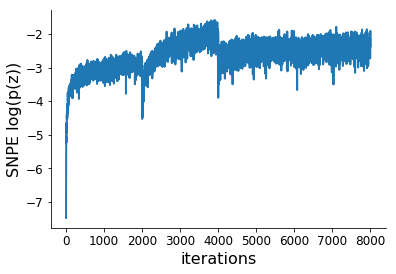

In [5]:
_losses = np.array(losses)
plt.figure()
plt.plot(-_losses)
plt.xlabel('iterations')
plt.ylabel('SNPE log(p(z))')
plt.show()

In [6]:
x0_torch = torch.tensor(x0).float()
z, log_prob= cnf(x0_torch, N=100)

<Figure size 432x288 with 0 Axes>

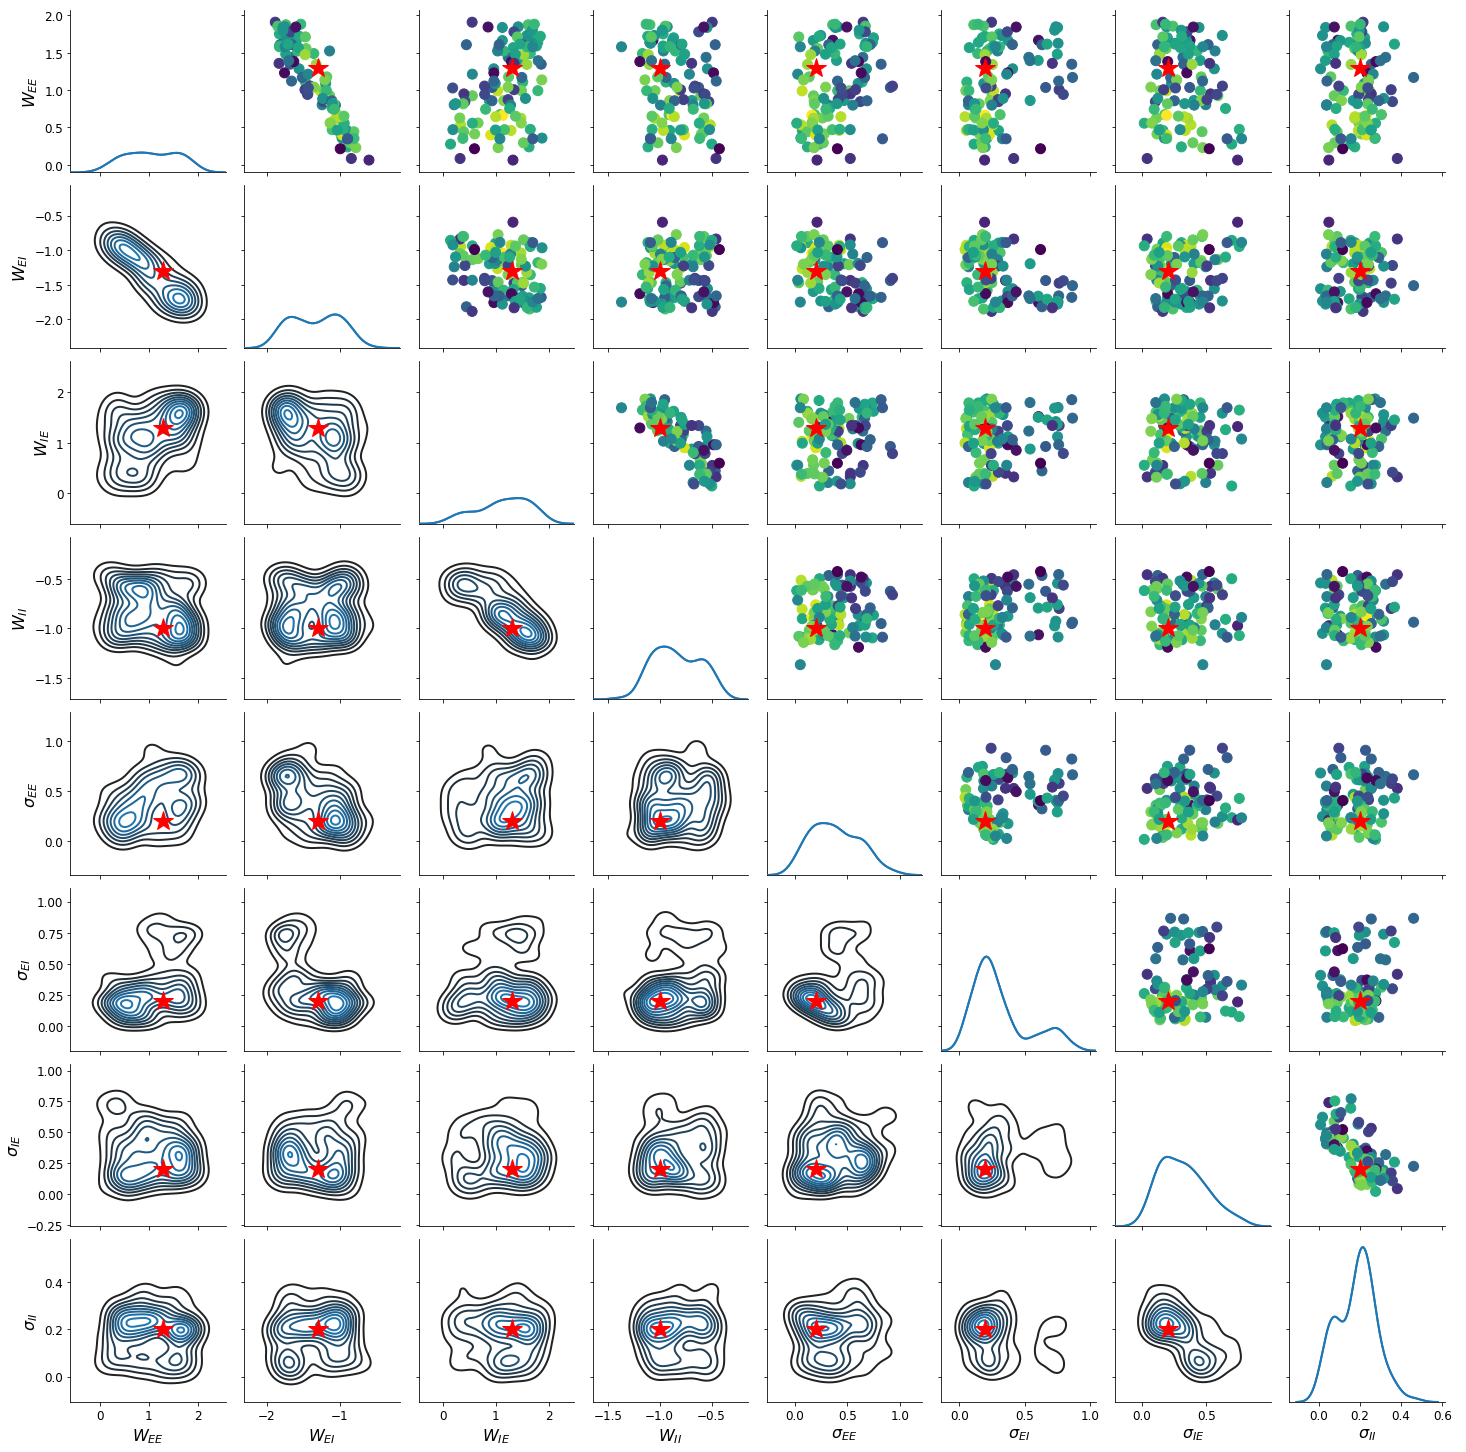

In [7]:
plt.figure()
g = plot_dist(
    z.detach().numpy()[0], 
    log_prob.detach().numpy()[0], 
    kde=True, z0=z0[0], 
    z_labels=system.z_labels
)
